# 1.Load data

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('ner_dataset.csv', encoding= 'unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [3]:
data.shape

(1048575, 4)

## 2. Extract mappings required for the neural network


In [4]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

In [5]:
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx) 

In [6]:
data.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,17915,0
1,NaN,of,IN,O,8380,0
2,NaN,demonstrators,NNS,O,31871,0
3,NaN,have,VBP,O,27280,0
4,NaN,marched,VBN,O,1825,0


## 3. Transform columns to extract sequential data


In [7]:
data.isna().any()

Sentence #     True
Word          False
POS           False
Tag           False
Word_idx      False
Tag_idx       False
dtype: bool

In [8]:
data_fillna = data.fillna(method='ffill', axis=0)
data_group = data_fillna.groupby(['Sentence #'],as_index=False
                                )['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

data_group.head()

<ipython-input-8-49b29f2cea66>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_group = data_fillna.groupby(['Sentence #'],as_index=False


,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[17915, 8380, 31871, 27280, 1825, 26342, 24109...","[0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0, 14, 0, 0..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[10040, 24912, 19454, 31360, 5989, 16626, 2079...","[10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[9545, 31567, 21858, 3923, 8271, 26061, 25697,...","[0, 0, 7, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0, 3,..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[33122, 21818, 10272, 7696, 34798, 4189, 8914,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[19542, 8281, 8107, 14510, 3245, 27469, 23095,...","[14, 0, 0, 15, 1, 0, 7, 0, 14, 0, 10, 0, 10, 0..."


## 4. Pad sequences and split the dataset into train, test


In [9]:
!pip install tensorflow

In [10]:
!pip install keras

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

#from keras.utils import to_categorical

In [11]:
def get_pad_train_test_val(data_group, data):
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))
    
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)
    
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    
    train_tokens, test_tokens, train_tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntrain_tags:', len(train_tags),
        '\ntest_tags:', len(test_tags)
    )
    
    return train_tokens, test_tokens, train_tags, test_tags

train_tokens, test_tokens, train_tags, test_tags = get_pad_train_test_val(data_group, data)

train_tokens length: 43163 
test_tokens length: 4796 
train_tags: 43163 
test_tags: 4796


In [12]:
for token, tag in zip(train_tokens[0], train_tags[0]):
    print('%s\t%s' % (token, tag))

19452	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
19454	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6658	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
22789	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
9566	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
10658	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
16626	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
35146	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
20341	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
26045	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
15732	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3949	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
31360	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
14038	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
10796	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4105	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
11450	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6

## 5. Build Model Layout

In [13]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

# import keras as k

In [14]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [15]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 32
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  35179 
output_dim:  32 
input_length:  104 
n_tags:  17


In [16]:
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [17]:
def train_model(X, y, model):
    loss = list()
    for _ in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss
model_bilstm_lstm = get_bilstm_lstm_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 32)           1125728   
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 64)           16640     
_________________________________________________________________
lstm_1 (LSTM)                (None, 104, 32)           12416     
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 17)           561       
Total params: 1,155,345
Trainable params: 1,155,345
Non-trainable params: 0
_________________________________________________________________
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [18]:
results = pd.DataFrame()
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

35/35 [==============================] - 363s 10s/step - loss: 0.0878 - accuracy: 0.9696 - val_loss: 0.1019 - val_accuracy: 0.9699


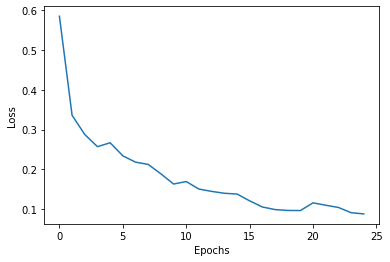

In [19]:
import matplotlib.pyplot as plt
plt.plot(results['with_add_lstm'])
plt.xlabel('Epochs');
plt.ylabel('Loss');

## spaCy 

In [21]:
!pip install spacy

In [27]:
pip install -U spacy

Requirement already up-to-date: spacy in c:\users\nimesh\anaconda3\lib\site-packages (3.1.2)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')


In [8]:
!pip install tika

  Created wheel for tika: filename=tika-1.24-py3-none-any.whl size=32888 sha256=801ec94805fba699b842c3df3cd90e900c652496a3d1c0bdcec547f09eef256d
  Stored in directory: c:\users\nimesh\appdata\local\pip\cache\wheels\75\66\8b\d1acbac7d49f3d98ade76c51ae5d72cec1866131a3b1ad9f82
Successfully built tika


In [10]:
from tika import parser # pip install tika

raw = parser.from_file('SamplePaper.pdf')
print(raw['content'])

2021-08-27 14:52:31,532 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to C:\Users\Nimesh\AppData\Local\Temp\tika-server.jar.
2021-08-27 14:52:47,371 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to C:\Users\Nimesh\AppData\Local\Temp\tika-server.jar.md5.
2021-08-27 14:52:48,259 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...
2021-08-27 14:52:53,269 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...




































































Biomedical named entity recognition using deep neural networks with contextual information


Cho and Lee BMC Bioinformatics          (2019) 20:735 
https://doi.org/10.1186/s12859-019-3321-4

RESEARCH ARTICLE Open Access

Biomedical named entity recognition
using deep neural networks with contextual
information
Hyejin Cho and Hyunju Lee*

Abstract

Background: In biomedical text mining, named entity recognition (NER) is an important task used to extract
information from biomedical articles. Previously proposed methods for NER are dictionary- or rule-based methods
and machine learning approaches. However, these traditional approaches are heavily reliant on large-scale
dictionaries, target-specific rules, or well-constructed corpora. These methods to NER have been superseded by the
deep learning-based approach that is independent of hand-crafted features. However, although such methods of NER
employ additional conditional r

In [11]:
text = nlp(raw['content'])

In [12]:
for w in text.ents:
    print(w.text, w.label_)

Biomedical ORG
Cho PERSON
Lee BMC Bioinformatics PERSON
2019 DATE
20:735 CARDINAL
Hyejin Cho PERSON
Hyunju Lee PERSON
NER ORG
NER ORG
NER ORG
NER ORG
BiLSTM ORG
three CARDINAL
the National Center for
Biotechnology Information ORG
NCBI ORG
BioCreative II ORG
GM ORG
CDR ORG
BiLSTM ORG
GRAM-CNN ORG
BERT ORG
NCBI ORG
85.68% PERCENT
1.50% PERCENT
BERT ORG
more than 2.5 billion MONEY
BERT ORG
an F-scores PRODUCT
81.44% PERCENT
GM ORG
86.44% PERCENT
CDR ORG
NER ORG
1 CARDINAL
2 CARDINAL
3 CARDINAL
hyunjulee@gist.ac.kr CARDINAL
Gwangju Institute ORG
123 CARDINAL
Chemdangwagi NORP
Buk-gu PERSON
Gwangju PERSON
Korea GPE
4 CARDINAL
NLP ORG
5–8 CARDINAL
NER ORG
9 CARDINAL
NER ORG
the Creative Commons Attribution ORG
4.0 CARDINAL
The Creative Commons Public Domain Dedication ORG
hyunjulee@gist.ac.kr CARDINAL
Cho PERSON
Lee BMC Bioinformatics PERSON
2019 DATE
20:735 CARDINAL
2 CARDINAL
11 CARDINAL
NLP ORG
NER ORG
synonyms GPE
11 CARDINAL
12 CARDINAL
1 CARDINAL
NER ORG
7, 9, 13 DATE
11 CARDINAL
7, 8 

NA ORG
Abdul Hamid J. Semantics PERSON
CRM PRODUCT
Inf Commun Technol PERSON
Cho K PERSON
Van Merriënboer B, Gulcehre C PERSON
Bahdanau D PERSON
Bougares F PERSON
Schwenk H PERSON
Bengio Y. Learning PERSON
RNN ORG
2014 DATE
48 CARDINAL
Kim Y. Convolutional PERSON
2014 DATE
49 DATE
LeCun Y PRODUCT
Bengio Y PERSON
Hinton G. Deep PERSON
2015;521(7553):436 CARDINAL
50 CARDINAL
Collobert R PERSON
Weston J PERSON
Bottou L ORG
Karlen M ORG
Kavukcuoglu K GPE
Kuksa P.

 PERSON
Mach Learn Res PERSON
Nature WORK_OF_ART
Discussion
	Error ORG
Conclusions
	Methods
	 ORG
CLSTM
	 PRODUCT


In [13]:
displacy.render(text, style = 'ent', jupyter=True)